In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from yolo_threat import YoloThreat
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tune import Tuner
import pandas as pd

In [15]:
# select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##### Loading the training and testing data tensors and moving them to device selected

In [16]:
Xtrain = torch.load('../data/danger/raw/train.pt').to(device)
ytrain = torch.load('../data/danger/raw/train_labels.pt').to(device)
Xtest = torch.load('../data/danger/raw/test.pt').to(device)
ytest = torch.load('../data/danger/raw/test_labels.pt').to(device)
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

(torch.Size([8736, 3, 128, 128]),
 torch.Size([8736]),
 torch.Size([2185, 3, 128, 128]),
 torch.Size([2185]))

##### Model initialization and loading trained model 

In [17]:
model = YoloThreat.load_new_model().to(device)
# loading pretrained model
model.load_state_dict(torch.load('trained_model.pt', map_location=device))

Using cache found in /s/chopin/k/grad/c837304112/.cache/torch/hub/ultralytics_yolov5_master


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.2', 'tqdm>=4.66.3', 'setuptools>=70.0.0'] not found, attempting AutoUpdate...


ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/usr/local/python-env/py39/bin/tqdm'



Retry 1/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.
Retry 2/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.
requirements: ❌ Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.


ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/usr/local/python-env/py39/bin/tqdm'

YOLOv5 🚀 2024-12-8 Python-3.9.20 torch-1.12.0+cu116 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20147MiB)

Fusing layers... 
YOLOv5n6 summary: 280 layers, 3239884 parameters, 0 gradients
Adding AutoShape... 


<All keys matched successfully>

##### Using Tuner on the trained model

In [19]:
tuner = Tuner(model,(Xtrain, ytrain))

##### FGSM(Fast Gradient Sign Method) to add adversarial examples to dataset
- Uses custom loss function defined tuner which combines Binary Cross Entropy with L2 term
- Processes the images in batches, to handle large datasets
- the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

In [20]:
def fgsm_attack(model, images, labels, epsilon, batch_size=32):
    """
    FGSM attack with batch processing and custom loss.

    Args:
        model: The trained model.
        images: Input data (images).
        labels: True labels.
        epsilon: Perturbation strength for FGSM.
        batch_size: Batch size for processing.

    Returns:
        Adversarial examples as a tensor.
    """
    adv_images = []
    custom_loss = tuner.get_loss(0.01)
    model.eval()  # Set model to evaluation mode for FGSM attack
    for i in range(0, images.size(0), batch_size):
        images_batch = images[i:i + batch_size].detach().clone()
        labels_batch = labels[i:i + batch_size].detach().clone()

        images_batch.requires_grad = True
        outputs = model(images_batch)
        loss = custom_loss(outputs.squeeze(-1), labels_batch.float())
        model.zero_grad()
        loss.backward()
        perturbed_batch = images_batch + epsilon * images_batch.grad.sign()
        adv_images.append(torch.clamp(perturbed_batch, 0, 1))  # Clamp to valid range

    return torch.cat(adv_images, dim=0)


**Evaluates the performance of the trained model on the test dataset.**
**This function utilizes the same test function, as the one used for Yolo, it just adds three new metrics for precision, recall and F1 Score.**

**The function returns the following values**
- Accuracy: describing the number of correct predictions over all predictions
- Precision: is a measure of how many of the positive predictions made are correct (true positives).
- Recall: is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data
- F1 Score: is a measure combining both precision and recall. It is generally described as the harmonic mean of the two. Harmonic mean is just another way to calculate an “average” of values, generally described as more suitable for ratios (such as precision and recall) than the traditional arithmetic mean


In [21]:
def test(model_t, X, y):
    model_t.eval()
    with torch.no_grad():
        y_pred = model_t.forward(X)
        y_pred = torch.sigmoid(y_pred)
        y_pred = (y_pred > 0.5).float().reshape(-1)
        accuracy = np.mean((y_pred.cpu() == y.cpu()).numpy())
        y_true = y.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        return accuracy, precision, recall, f1

**The function evaluates the attacking function (FGSM) for different values of Epsilon**
- Epsilon values decides the strength of adversarial perturbations that are added to the input.
- A larger value of epsilon, increases the strength of the attack, but larger values have a drawback, that the perturbed image can be detected more easily compared to the normal images.
- This function also returns the same metrics as the test function:
  1. Accuracy
  2. Precision
  3. Recall
  4. F1 Score

In [22]:
def evaluate_with_epsilon(model, X, y, epsilons, attack_fn, attack_name):
    results = {}
    for epsilon in epsilons:
        print(f"Evaluating {attack_name} attack with epsilon={epsilon:.3f}")
        if attack_name == "Normal":
            perturbed_X = X
        else:
            perturbed_X = attack_fn(model, X, y, epsilon=epsilon)

        acc, precision, recall, f1 = test(model, perturbed_X, y)
        results[epsilon] = {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }
        print(f"Epsilon={epsilon:.3f} | Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    return results


**The function evaluates the normal model, as well as the perturbed model, for different noise levels**

- Gaussian noise is the real world perturbations that can affect the input dataset. 
- For example, in case of computer vision, the affect of light while capturing images, blurry images and so on. 
- We add the noise to the inputs, so that we can consider the real world scenarios while capturing the images via our doorbell setup.
- With increasing values of noise the accuracy of the model drops

- This function also returns the same metrics as the test function:
1. Accuracy
2. Precision
3. Recall
4. F1 Score

In [23]:
def evaluate_with_noise(model, X, y, noise_levels, attack_fn=None, epsilon=0, label="Evaluation with Noise"):
    """
    Evaluate model performance under varying noise levels, with or without FGSM attacks.

    Args:
        model: The trained model.
        X: Input data.
        y: True labels.
        noise_levels: List of noise levels to add to the input data.
        attack_fn: Adversarial attack function (e.g., FGSM), default is None for no attack.
        epsilon: Perturbation strength for FGSM, if applicable.
        label: Label for the evaluation (e.g., "Normal with Noise" or "FGSM with Noise").

    Returns:
        A dictionary of results for different noise levels.
    """
    results = {}
    for noise_level in noise_levels:
        print(f"Evaluating {label} with noise level: {noise_level:.3f}")

        if noise_level != 0:
            noisy_X = X + noise_level * torch.randn_like(X).to(X.device)
            noisy_X = torch.clamp(noisy_X, 0, 1)  # Clip values to valid range [0, 1]
        else:
            noisy_X = X

        # Handle FGSM attack (only if attack_fn is provided)
        if attack_fn:
            try:
                perturbed_X = attack_fn(model, noisy_X, y, epsilon=epsilon)
            except Exception as e:
                print(f"Error during {label} attack: {e}")
                perturbed_X = noisy_X  # Fallback to noisy input if FGSM fails
        else:
            perturbed_X = noisy_X  # For normal evaluation, only noisy data is used

        try:
            acc, precision, recall, f1 = test(model, perturbed_X, y)
            results[noise_level] = {
                "accuracy": acc,
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
            }
            print(
                f"Results (Noise={noise_level:.3f}): Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
            )
        except Exception as e:
            print(f"Error during evaluation at noise level {noise_level:.3f}: {e}")
            results[noise_level] = {
                "accuracy": None,
                "precision": None,
                "recall": None,
                "f1_score": None,
            }

    return results



**The plot results plots the different plots required to show the results of the experiments we ran**
- The plot function is used to plot the following plots:
    1. Accuracy vs Noise: Trained Model
    2. Accuracy vs Noise: Adversarial Model
    3. Accuracy vs Epsilon: FGSM attack on trained model
    4. Accuracy vs Noise: FSGM attack on trained model
    5. Accuracy vs Epsilon: FGSM attack on adversarial model
    6. Accuracy vs Noise: FGSM attack on adversarial model
 - this returns a plot with title, legend, xlabel, ylabel

In [33]:
%matplotlib inline
def plot_results(results_dict, x_label, title):
    """
    Plot results for accuracy against varying noise or epsilon.

    Args:
        results_dict: Dictionary containing results for plotting.
        x_label: Label for the x-axis (e.g., "Noise Level", "Epsilon").
        title: Plot title.
    """
    plt.figure(figsize=(8, 6))
    for method, results in results_dict.items():
        x_values = list(results.keys())
        accuracies = [metrics["accuracy"] for metrics in results.values()]
        plt.plot(x_values, accuracies, marker='o', label=method)

    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
# This defines values for epsilons, and noise_levels to be used in the experiment
epsilons = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
noise_levels = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

**The below plot shows different images being perturbed using fgsm attack with an epsilon value of 0.2**
- used matplotlib inline as sometimes plot is not shown normally in the notebook

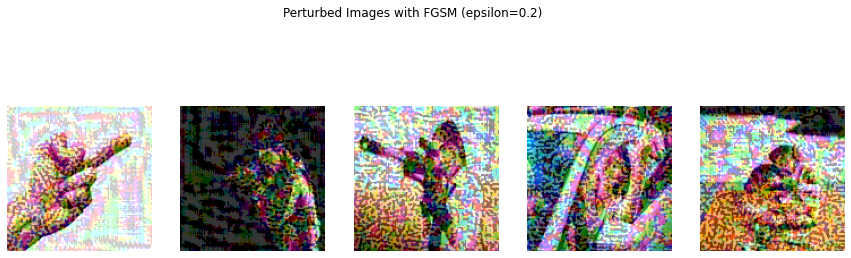

In [66]:

epsilon = 0.2
perturbed_images = fgsm_attack(model, Xtest[:5], ytest[:5], epsilon)
%matplotlib inline
# Plot the perturbed images
plt.figure(figsize=(15, 5))  # Adjust the figure size for better visualization
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # Detach the tensor and convert to NumPy
    plt.imshow(perturbed_images[i].detach().cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
plt.suptitle(f"Perturbed Images with FGSM (epsilon={epsilon})")
plt.show()

In [67]:
# testing the trained model, along with accuracy other metrics are also returned
print("Evaluating normal model performance...")
accuracy, precision, recall, f1 = test(model, Xtest, ytest)
normal_results = {0: {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}}

Evaluating normal model performance...


- **this cell generates the dataframe to show the different evaluation metrics, the index column is replaced with epsilon**
- **In real world scenario epsilon is not used without FGSM attack, therefore the value of epsilon is 0 for normallly trained model**

In [68]:

normal_results
normal_results_df = pd.DataFrame.from_dict(normal_results, orient='index').reset_index()

# Rename the 'index' column to 'Epsilon'
normal_results_df.rename(columns={'index': 'Epsilon'}, inplace=True)
normal_results_df

,Epsilon,accuracy,precision,recall,f1_score
0,0,0.691533,0.859083,0.461258,0.600237


In [69]:
# evaluating the trained model, with different values of noise
normal_noise_results = evaluate_with_noise(model, Xtest, ytest, noise_levels, attack_fn=None, label="Normal with Noise")

Evaluating Normal with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.6915, Precision=0.8591, Recall=0.4613, F1=0.6002
Evaluating Normal with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.6481, Precision=0.7780, Recall=0.4184, F1=0.5442
Evaluating Normal with Noise with noise level: 0.150
Results (Noise=0.150): Accuracy=0.6307, Precision=0.7126, Recall=0.4430, F1=0.5464
Evaluating Normal with Noise with noise level: 0.200
Results (Noise=0.200): Accuracy=0.6238, Precision=0.6928, Recall=0.4503, F1=0.5459
Evaluating Normal with Noise with noise level: 0.250
Results (Noise=0.250): Accuracy=0.5945, Precision=0.6492, Recall=0.4184, F1=0.5089
Evaluating Normal with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.5918, Precision=0.6442, Recall=0.4175, F1=0.5066
Evaluating Normal with Noise with noise level: 0.350
Results (Noise=0.350): Accuracy=0.5785, Precision=0.6215, Recall=0.4102, F1=0.4942
Evaluating Normal with Noise with noise level: 0

- **this cell generates the dataframe to show the different evaluation metrics for the trained and tuned yolo v5 model, the index column is replaced with noise**

In [70]:
normal_noise_results
normal_noise_results_df = pd.DataFrame.from_dict(normal_noise_results, orient='index').reset_index()
normal_noise_results_df.rename(columns={'index': 'Noise'}, inplace=True)
normal_noise_results_df

,Noise,accuracy,precision,recall,f1_score
0,0.00,0.691533,0.859083,0.461258,0.600237
1,0.10,0.648055,0.777966,0.418414,0.544161
2,0.15,0.630664,0.712610,0.443026,0.546374
3,0.20,0.623799,0.692847,0.450319,0.545856
4,0.25,0.594508,0.649222,0.418414,0.508869
5,0.30,0.591762,0.644163,0.417502,0.506637
6,0.35,0.578490,0.621547,0.410210,0.494234
7,0.40,0.573455,0.620438,0.387420,0.476992
8,0.45,0.537757,0.564829,0.345488,0.428733
9,0.50,0.551487,0.590417,0.348222,0.438073


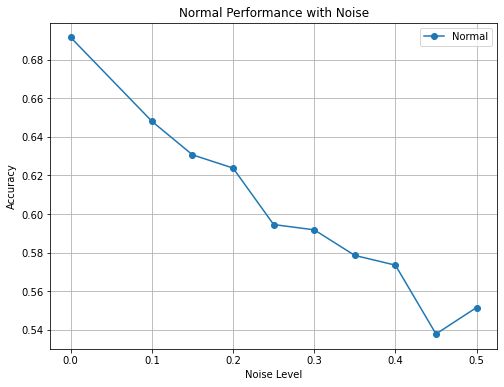

In [71]:
# this line plots, accuracy vs noise plot for the originally trained model
plot_results({"Normal": normal_noise_results}, "Noise Level", "Normal Performance with Noise")

- **testing the trained model by adding adversarial perturbations using FGSM attack for different values of epsilon**
- **This returns the metrics for different values of epsilon**

In [72]:
fgsm_epsilon_results = evaluate_with_epsilon(model, Xtest, ytest, epsilons, fgsm_attack, "FGSM")
fgsm_epsilon_results

Evaluating FGSM attack with epsilon=0.000
Epsilon=0.000 | Acc: 0.6915, Precision: 0.8591, Recall: 0.4613, F1: 0.6002
Evaluating FGSM attack with epsilon=0.100
Epsilon=0.100 | Acc: 0.4343, Precision: 0.3618, Recall: 0.1659, F1: 0.2275
Evaluating FGSM attack with epsilon=0.150
Epsilon=0.150 | Acc: 0.4838, Precision: 0.4652, Recall: 0.1887, F1: 0.2685
Evaluating FGSM attack with epsilon=0.200
Epsilon=0.200 | Acc: 0.5011, Precision: 0.5100, Recall: 0.1632, F1: 0.2472
Evaluating FGSM attack with epsilon=0.250
Epsilon=0.250 | Acc: 0.5126, Precision: 0.5567, Recall: 0.1431, F1: 0.2277
Evaluating FGSM attack with epsilon=0.300
Epsilon=0.300 | Acc: 0.5103, Precision: 0.5634, Recall: 0.1094, F1: 0.1832
Evaluating FGSM attack with epsilon=0.350
Epsilon=0.350 | Acc: 0.5130, Precision: 0.6170, Recall: 0.0793, F1: 0.1405
Evaluating FGSM attack with epsilon=0.400
Epsilon=0.400 | Acc: 0.5140, Precision: 0.6496, Recall: 0.0693, F1: 0.1252
Evaluating FGSM attack with epsilon=0.450
Epsilon=0.450 | Acc: 0

{0: {'accuracy': 0.691533180778032,
  'precision': 0.8590831918505942,
  'recall': 0.4612579762989973,
  'f1_score': 0.6002372479240806},
 0.1: {'accuracy': 0.43432494279176204,
  'precision': 0.36182902584493043,
  'recall': 0.1659070191431176,
  'f1_score': 0.2275},
 0.15: {'accuracy': 0.4837528604118993,
  'precision': 0.4651685393258427,
  'recall': 0.18869644484958978,
  'f1_score': 0.26848249027237353},
 0.2: {'accuracy': 0.5011441647597255,
  'precision': 0.50997150997151,
  'recall': 0.16317228805834094,
  'f1_score': 0.24723756906077352},
 0.25: {'accuracy': 0.5125858123569794,
  'precision': 0.5567375886524822,
  'recall': 0.1431175934366454,
  'f1_score': 0.22770123277737492},
 0.3: {'accuracy': 0.5102974828375286,
  'precision': 0.5633802816901409,
  'recall': 0.10938924339106655,
  'f1_score': 0.183206106870229},
 0.35: {'accuracy': 0.5130434782608696,
  'precision': 0.6170212765957447,
  'recall': 0.07930720145852324,
  'f1_score': 0.14054927302100162},
 0.4: {'accuracy':

In [73]:
# this cell generates the dataframe to show the different evaluation metrics for testing the trained model by attacking with FGSM attack for different values of epsilon
fgsm_epsilon_results_df = pd.DataFrame.from_dict(fgsm_epsilon_results, orient='index').reset_index()
fgsm_epsilon_results_df.rename(columns={'index': 'Epsilon'}, inplace=True)
fgsm_epsilon_results_df

,Epsilon,accuracy,precision,recall,f1_score
0,0.00,0.691533,0.859083,0.461258,0.600237
1,0.10,0.434325,0.361829,0.165907,0.227500
2,0.15,0.483753,0.465169,0.188696,0.268482
3,0.20,0.501144,0.509972,0.163172,0.247238
4,0.25,0.512586,0.556738,0.143118,0.227701
5,0.30,0.510297,0.563380,0.109389,0.183206
6,0.35,0.513043,0.617021,0.079307,0.140549
7,0.40,0.513959,0.649573,0.069280,0.125206
8,0.45,0.514416,0.695652,0.058341,0.107653
9,0.50,0.509840,0.691176,0.042844,0.080687


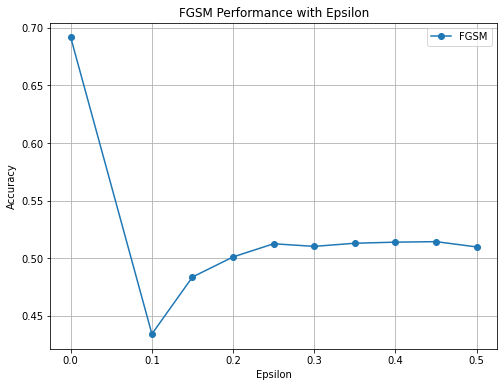

In [75]:
# # this line plots, accuracy vs epsilpn plot for the originally trained model attacked with FGSM
plot_results({"FGSM": fgsm_epsilon_results}, "Epsilon", "FGSM Performance with Epsilon")

- **testing the trained model by adding adversarial perturbations using FGSM attack for different values of noise**
- **This returns the metrics for different values of noise**
- **The value of epsilon is fixed at 0.1 and 0.3 for experiment purposes**

In [77]:
fgsm_noise_results = evaluate_with_noise(model, Xtest, ytest, noise_levels, attack_fn=fgsm_attack, epsilon=0.1, label="FGSM with Noise")

Evaluating FGSM with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.4339, Precision=0.3611, Recall=0.1659, F1=0.2274
Evaluating FGSM with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.3259, Precision=0.2035, Recall=0.1176, F1=0.1490
Evaluating FGSM with Noise with noise level: 0.150
Results (Noise=0.150): Accuracy=0.2888, Precision=0.1703, Recall=0.1076, F1=0.1318
Evaluating FGSM with Noise with noise level: 0.200
Results (Noise=0.200): Accuracy=0.2490, Precision=0.1294, Recall=0.0866, F1=0.1038
Evaluating FGSM with Noise with noise level: 0.250
Results (Noise=0.250): Accuracy=0.2279, Precision=0.1218, Recall=0.0866, F1=0.1012
Evaluating FGSM with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.2018, Precision=0.0991, Recall=0.0729, F1=0.0840
Evaluating FGSM with Noise with noise level: 0.350
Results (Noise=0.350): Accuracy=0.2005, Precision=0.0833, Recall=0.0593, F1=0.0693
Evaluating FGSM with Noise with noise level: 0.400
Results (No

In [78]:
fgsm_noise_results_df = pd.DataFrame.from_dict(fgsm_noise_results, orient='index').reset_index()
fgsm_noise_results_df.rename(columns={'index': 'Noise'}, inplace=True)
fgsm_noise_results_df

,Noise,accuracy,precision,recall,f1_score
0,0.00,0.433867,0.361111,0.165907,0.227358
1,0.10,0.325858,0.203470,0.117593,0.149047
2,0.15,0.288787,0.170274,0.107566,0.131844
3,0.20,0.248970,0.129428,0.086600,0.103768
4,0.25,0.227918,0.121795,0.086600,0.101225
5,0.30,0.201831,0.099133,0.072926,0.084034
6,0.35,0.200458,0.083333,0.059253,0.069259
7,0.40,0.175286,0.070646,0.052871,0.060480
8,0.45,0.162929,0.052567,0.039198,0.044909
9,0.50,0.153318,0.048019,0.036463,0.041451


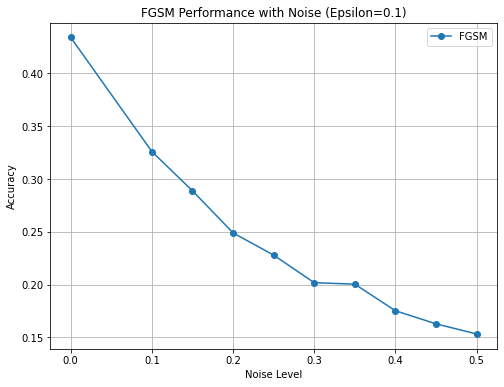

In [79]:
# this plots the accuracy vs noise plot for FGSM attack with epsilon 0.1
plot_results({"FGSM": fgsm_noise_results}, "Noise Level", "FGSM Performance with Noise (Epsilon=0.1)")

In [81]:
# repeating the same experiment with epsilon 0.3
fgsm_noise_results_eps_03 = evaluate_with_noise(model, Xtest, ytest, noise_levels, attack_fn=fgsm_attack, epsilon=0.3, label="FGSM with Noise")

Evaluating FGSM with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.5085, Precision=0.5540, Recall=0.1076, F1=0.1802
Evaluating FGSM with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.4902, Precision=0.4593, Recall=0.0875, F1=0.1470
Evaluating FGSM with Noise with noise level: 0.150
Results (Noise=0.150): Accuracy=0.4870, Precision=0.4341, Recall=0.0720, F1=0.1235
Evaluating FGSM with Noise with noise level: 0.200
Results (Noise=0.200): Accuracy=0.4453, Precision=0.2374, Recall=0.0474, F1=0.0790
Evaluating FGSM with Noise with noise level: 0.250
Results (Noise=0.250): Accuracy=0.4339, Precision=0.1818, Recall=0.0365, F1=0.0607
Evaluating FGSM with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.4133, Precision=0.1456, Recall=0.0346, F1=0.0560
Evaluating FGSM with Noise with noise level: 0.350
Results (Noise=0.350): Accuracy=0.3854, Precision=0.1006, Recall=0.0283, F1=0.0441
Evaluating FGSM with Noise with noise level: 0.400
Results (No

In [82]:
fgsm_noise_results_df_03 = pd.DataFrame.from_dict(fgsm_noise_results_eps_03, orient='index').reset_index()
fgsm_noise_results_df_03.rename(columns={'index': 'Noise'}, inplace=True)
fgsm_noise_results_df_03

,Noise,accuracy,precision,recall,f1_score
0,0.00,0.508467,0.553991,0.107566,0.180153
1,0.10,0.490160,0.459330,0.087511,0.147014
2,0.15,0.486957,0.434066,0.072015,0.123534
3,0.20,0.445309,0.237443,0.047402,0.079027
4,0.25,0.433867,0.181818,0.036463,0.060744
5,0.30,0.413272,0.145594,0.034640,0.055965
6,0.35,0.385355,0.100649,0.028259,0.044128
7,0.40,0.368879,0.087719,0.027347,0.041696
8,0.45,0.341876,0.059432,0.020966,0.030997
9,0.50,0.319908,0.038005,0.014585,0.021080


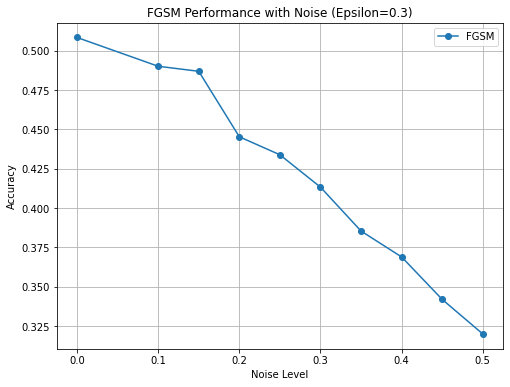

In [83]:
# this plots the accuracy vs noise plot for FGSM attack with epsilon 0.3
plot_results({"FGSM": fgsm_noise_results_eps_03}, "Noise Level", "FGSM Performance with Noise (Epsilon=0.3)")

**The below function does the adversarial training for the input dataset**
The following steps are done for the adversarial training
- Loads the existing train dataset
- Generates the adversarial examples using FGSM attack
- Uses the same loss function as used for training dataset
- combines the adversarial dataset with the original dataset, to generate the new dataset
- uses tuner's tune class to generate the adversarial model

In [84]:
def adversarial_training_with_tuner(
    tuner,
    model,
    Xtrain,
    ytrain,
    epsilon=0.1,
    lam=0.01,
    batch_size=64,
    epochs=30,
    lr=0.001
):
    """
    Adversarial training using FGSM attacks.

    Args:
        tuner: Tuner class for training.
        model: Neural network model.
        Xtrain, ytrain: Training data and labels.
        epsilon: Perturbation strength for FGSM.
        lam: Regularization weight for custom loss.
        batch_size: Batch size for training.
        epochs: Number of epochs for training.
        lr: Learning rate for the optimizer.

    Returns:
        Trained model.
    """

    # Prepare data loader for clean examples
    train_dataset = TensorDataset(Xtrain, ytrain)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    combined_X = []
    combined_y = []

    # Generate combined clean and adversarial examples
    model.eval()  # Set model to evaluation mode for FGSM attack
    for X_batch, y_batch in train_loader:
        # Append clean examples
        combined_X.append(X_batch)
        combined_y.append(y_batch)

        # Generate FGSM adversarial examples using the custom loss
        adv_X = fgsm_attack(
            model, X_batch, y_batch, epsilon=epsilon, batch_size=batch_size
        )
        combined_X.append(adv_X)
        combined_y.append(y_batch)

    # Concatenate clean and adversarial examples
    combined_X = torch.cat(combined_X, dim=0)
    combined_y = torch.cat(combined_y, dim=0)

    # Perform adversarial training using tuner
    trained_model = tuner.tune(
        optimizer=optim.Adam,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        lam=lam,
    )

    return trained_model

- **The model is trained for an epsilon value of 0.1**
- **It runs for 30 epochs, with a learning rate of 0.001, and lambda value of 0.001**
- **the batch dize for the experiment is choosen as 64**

In [85]:
trained_model = adversarial_training_with_tuner(
    tuner=tuner,
    model=tuner.model,
    Xtrain=Xtrain,
    ytrain=ytrain,
    epsilon=0.1,
    lam=0.01,
    batch_size=64,
    epochs=30,
    lr=0.001
)

Epoch 0, Batch 27, Loss: 0.838276743888855
Validation Loss: 28.34811794757843
Epoch 1, Batch 27, Loss: 0.9321790933609009
Validation Loss: 29.263355672359467
Epoch 2, Batch 27, Loss: 0.8630263805389404
Validation Loss: 25.23327898979187
Epoch 3, Batch 27, Loss: 0.6549245715141296
Validation Loss: 29.848354816436768
Epoch 4, Batch 27, Loss: 0.7604169845581055
Validation Loss: 40.54452037811279
Epoch 5, Batch 27, Loss: 0.7478969097137451
Validation Loss: 36.602988600730896
Epoch 6, Batch 27, Loss: 0.7214161157608032
Validation Loss: 27.497827649116516
Epoch 7, Batch 27, Loss: 0.45529380440711975
Validation Loss: 25.892970621585846
Epoch 8, Batch 27, Loss: 0.5545831918716431
Validation Loss: 27.039371848106384
Epoch 9, Batch 27, Loss: 0.6287497282028198
Validation Loss: 33.03037071228027
Epoch 10, Batch 27, Loss: 0.8299946784973145
Validation Loss: 42.53852117061615
Epoch 11, Batch 27, Loss: 0.4523303210735321
Validation Loss: 43.53360217809677
Epoch 12, Batch 27, Loss: 0.3852907121181488

In [86]:
# Save the trained adversarial model for future use
torch.save(trained_model.state_dict(), "adversarial_trained_model.pt")
print("Trained model saved as 'adversarial_trained_model.pt'.")

Trained model saved as 'adversarial_trained_model.pt'.


In [87]:
print("Evaluating normal model performance...")
accuracy, precision, recall, f1 = test(trained_model, Xtest, ytest)
normal_results_adversarial = {0: {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}}
normal_results_adversarial

Evaluating normal model performance...


{0: {'accuracy': 0.7263157894736842,
  'precision': 0.7415295256534365,
  'recall': 0.6982680036463081,
  'f1_score': 0.7192488262910798}}

In [88]:
normal_results_adversarial_df = pd.DataFrame.from_dict(normal_results_adversarial, orient='index').reset_index()

# Rename the 'index' column to 'Epsilon'
normal_results_adversarial_df.rename(columns={'index': 'Epsilon'}, inplace=True)
normal_results_adversarial_df

,Epsilon,accuracy,precision,recall,f1_score
0,0,0.726316,0.74153,0.698268,0.719249


In [89]:

normal_noise_results_adversarial = evaluate_with_noise(trained_model, Xtest, ytest, noise_levels, attack_fn=None, label="Normal with Noise")

Evaluating Normal with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.7263, Precision=0.7415, Recall=0.6983, F1=0.7192
Evaluating Normal with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.7085, Precision=0.7190, Recall=0.6882, F1=0.7033
Evaluating Normal with Noise with noise level: 0.150
Results (Noise=0.150): Accuracy=0.6902, Precision=0.6937, Recall=0.6855, F1=0.6896
Evaluating Normal with Noise with noise level: 0.200
Results (Noise=0.200): Accuracy=0.6577, Precision=0.6513, Recall=0.6846, F1=0.6676
Evaluating Normal with Noise with noise level: 0.250
Results (Noise=0.250): Accuracy=0.6352, Precision=0.6223, Recall=0.6955, F1=0.6569
Evaluating Normal with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.6188, Precision=0.6039, Recall=0.6992, F1=0.6481
Evaluating Normal with Noise with noise level: 0.350
Results (Noise=0.350): Accuracy=0.6188, Precision=0.6009, Recall=0.7165, F1=0.6536
Evaluating Normal with Noise with noise level: 0

In [90]:
normal_noise_results_adversarial
normal_noise_results_adversarial_df = pd.DataFrame.from_dict(normal_noise_results_adversarial, orient='index').reset_index()
normal_noise_results_adversarial_df.rename(columns={'index': 'Noise'}, inplace=True)
normal_noise_results_adversarial_df

,Noise,accuracy,precision,recall,f1_score
0,0.00,0.726316,0.741530,0.698268,0.719249
1,0.10,0.708467,0.719048,0.688241,0.703307
2,0.15,0.690160,0.693727,0.685506,0.689592
3,0.20,0.657666,0.651344,0.684594,0.667556
4,0.25,0.635240,0.622349,0.695533,0.656909
5,0.30,0.618764,0.603937,0.699180,0.648078
6,0.35,0.618764,0.600917,0.716500,0.653638
7,0.40,0.601831,0.584012,0.719234,0.644608
8,0.45,0.597254,0.578001,0.732908,0.646302
9,0.50,0.590389,0.571733,0.733820,0.642715


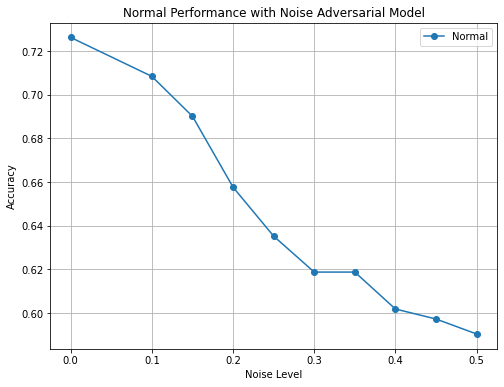

In [91]:
plot_results({"Normal": normal_noise_results_adversarial}, "Noise Level", "Normal Performance with Noise Adversarial Model")

In [92]:
fgsm_epsilon_results_adversarial = evaluate_with_epsilon(trained_model, Xtest, ytest, epsilons, fgsm_attack, "FGSM")
fgsm_epsilon_results_adversarial

Evaluating FGSM attack with epsilon=0.000
Epsilon=0.000 | Acc: 0.7263, Precision: 0.7415, Recall: 0.6983, F1: 0.7192
Evaluating FGSM attack with epsilon=0.100
Epsilon=0.100 | Acc: 0.0558, Precision: 0.0609, Recall: 0.0611, F1: 0.0610
Evaluating FGSM attack with epsilon=0.150
Epsilon=0.150 | Acc: 0.0911, Precision: 0.1042, Recall: 0.1067, F1: 0.1054
Evaluating FGSM attack with epsilon=0.200
Epsilon=0.200 | Acc: 0.1341, Precision: 0.1576, Recall: 0.1668, F1: 0.1621
Evaluating FGSM attack with epsilon=0.250
Epsilon=0.250 | Acc: 0.1547, Precision: 0.1849, Recall: 0.2005, F1: 0.1924
Evaluating FGSM attack with epsilon=0.300
Epsilon=0.300 | Acc: 0.1725, Precision: 0.2093, Recall: 0.2334, F1: 0.2207
Evaluating FGSM attack with epsilon=0.350
Epsilon=0.350 | Acc: 0.2009, Precision: 0.2418, Recall: 0.2771, F1: 0.2583
Evaluating FGSM attack with epsilon=0.400
Epsilon=0.400 | Acc: 0.2119, Precision: 0.2564, Recall: 0.2999, F1: 0.2765
Evaluating FGSM attack with epsilon=0.450
Epsilon=0.450 | Acc: 0

{0: {'accuracy': 0.7263157894736842,
  'precision': 0.7415295256534365,
  'recall': 0.6982680036463081,
  'f1_score': 0.7192488262910798},
 0.1: {'accuracy': 0.055835240274599546,
  'precision': 0.060909090909090906,
  'recall': 0.061075660893345485,
  'f1_score': 0.060992262175694124},
 0.15: {'accuracy': 0.09107551487414188,
  'precision': 0.10418521816562779,
  'recall': 0.10665451230628988,
  'f1_score': 0.1054054054054054},
 0.2: {'accuracy': 0.13409610983981693,
  'precision': 0.15762273901808785,
  'recall': 0.16681859617137648,
  'f1_score': 0.1620903454384411},
 0.25: {'accuracy': 0.15469107551487415,
  'precision': 0.18487394957983194,
  'recall': 0.20054694621695535,
  'f1_score': 0.19239177962396153},
 0.3: {'accuracy': 0.17254004576659038,
  'precision': 0.20932134096484056,
  'recall': 0.2333637192342753,
  'f1_score': 0.22068965517241382},
 0.35: {'accuracy': 0.20091533180778032,
  'precision': 0.24184566428003182,
  'recall': 0.27711941659070194,
  'f1_score': 0.2582837

In [93]:
fgsm_epsilon_results_adversarial_df = pd.DataFrame.from_dict(fgsm_epsilon_results_adversarial, orient='index').reset_index()
fgsm_epsilon_results_adversarial_df.rename(columns={'index': 'Epsilon'}, inplace=True)
fgsm_epsilon_results_adversarial_df

,Epsilon,accuracy,precision,recall,f1_score
0,0.00,0.726316,0.741530,0.698268,0.719249
1,0.10,0.055835,0.060909,0.061076,0.060992
2,0.15,0.091076,0.104185,0.106655,0.105405
3,0.20,0.134096,0.157623,0.166819,0.162090
4,0.25,0.154691,0.184874,0.200547,0.192392
5,0.30,0.172540,0.209321,0.233364,0.220690
6,0.35,0.200915,0.241846,0.277119,0.258284
7,0.40,0.211899,0.256430,0.299909,0.276471
8,0.45,0.229291,0.276806,0.331814,0.301824
9,0.50,0.256751,0.306676,0.381039,0.339837


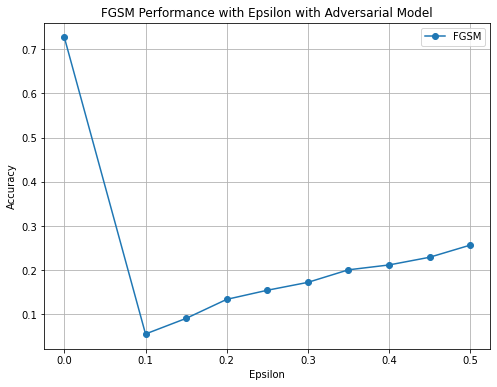

In [94]:
plot_results({"FGSM": fgsm_epsilon_results_adversarial}, "Epsilon", "FGSM Performance with Epsilon with Adversarial Model")

In [95]:
fgsm_noise_results_adversarial = evaluate_with_noise(trained_model, Xtest, ytest, noise_levels, attack_fn=fgsm_attack, epsilon=0.1, label="FGSM with Noise")

Evaluating FGSM with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.0558, Precision=0.0609, Recall=0.0611, F1=0.0610
Evaluating FGSM with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.0174, Precision=0.0210, Recall=0.0210, F1=0.0210
Evaluating FGSM with Noise with noise level: 0.150
Results (Noise=0.150): Accuracy=0.0023, Precision=0.0046, Recall=0.0046, F1=0.0046
Evaluating FGSM with Noise with noise level: 0.200
Results (Noise=0.200): Accuracy=0.0005, Precision=0.0009, Recall=0.0009, F1=0.0009
Evaluating FGSM with Noise with noise level: 0.250
Results (Noise=0.250): Accuracy=0.0018, Precision=0.0037, Recall=0.0036, F1=0.0037
Evaluating FGSM with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.0000, Precision=0.0000, Recall=0.0000, F1=0.0000
Evaluating FGSM with Noise with noise level: 0.350
Results (Noise=0.350): Accuracy=0.0000, Precision=0.0000, Recall=0.0000, F1=0.0000
Evaluating FGSM with Noise with noise level: 0.400
Results (No

In [96]:
fgsm_noise_results_adversarial_df = pd.DataFrame.from_dict(fgsm_noise_results_adversarial, orient='index').reset_index()
fgsm_noise_results_adversarial_df.rename(columns={'index': 'Noise'}, inplace=True)
fgsm_noise_results_adversarial_df

,Noise,accuracy,precision,recall,f1_score
0,0.00,0.055835,0.060909,0.061076,0.060992
1,0.10,0.017391,0.020985,0.020966,0.020976
2,0.15,0.002288,0.004575,0.004558,0.004566
3,0.20,0.000458,0.000918,0.000912,0.000915
4,0.25,0.001831,0.003663,0.003646,0.003655
5,0.30,0.000000,0.000000,0.000000,0.000000
6,0.35,0.000000,0.000000,0.000000,0.000000
7,0.40,0.000000,0.000000,0.000000,0.000000
8,0.45,0.000000,0.000000,0.000000,0.000000
9,0.50,0.000000,0.000000,0.000000,0.000000


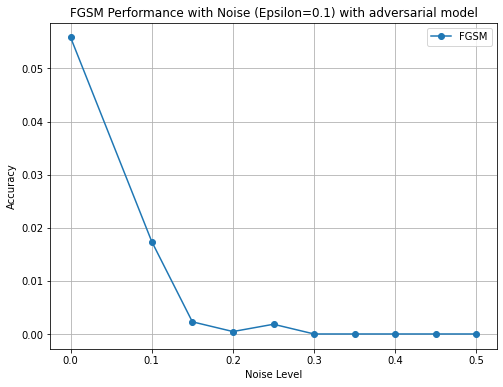

In [97]:
plot_results({"FGSM": fgsm_noise_results_adversarial}, "Noise Level", "FGSM Performance with Noise (Epsilon=0.1) with adversarial model")

In [98]:
fgsm_noise_results_adversarial_03 = evaluate_with_noise(trained_model, Xtest, ytest, noise_levels, attack_fn=fgsm_attack, epsilon=0.3, label="FGSM with Noise")

Evaluating FGSM with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.1712, Precision=0.2074, Recall=0.2306, F1=0.2184
Evaluating FGSM with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.0856, Precision=0.1120, Recall=0.1185, F1=0.1151
Evaluating FGSM with Noise with noise level: 0.150
Results (Noise=0.150): Accuracy=0.0485, Precision=0.0678, Recall=0.0702, F1=0.0690
Evaluating FGSM with Noise with noise level: 0.200
Results (Noise=0.200): Accuracy=0.0325, Precision=0.0439, Recall=0.0447, F1=0.0443
Evaluating FGSM with Noise with noise level: 0.250
Results (Noise=0.250): Accuracy=0.0238, Precision=0.0325, Recall=0.0328, F1=0.0327
Evaluating FGSM with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.0069, Precision=0.0109, Recall=0.0109, F1=0.0109
Evaluating FGSM with Noise with noise level: 0.350
Results (Noise=0.350): Accuracy=0.0055, Precision=0.0082, Recall=0.0082, F1=0.0082
Evaluating FGSM with Noise with noise level: 0.400
Results (No

In [99]:
fgsm_noise_results_adversarial_df_03 = pd.DataFrame.from_dict(fgsm_noise_results_adversarial_03, orient='index').reset_index()
fgsm_noise_results_adversarial_df_03.rename(columns={'index': 'Noise'}, inplace=True)
fgsm_noise_results_adversarial_df_03

,Noise,accuracy,precision,recall,f1_score
0,0.00,0.171167,0.207377,0.230629,0.218386
1,0.10,0.085584,0.111972,0.118505,0.115146
2,0.15,0.048513,0.067782,0.070191,0.068966
3,0.20,0.032494,0.043946,0.044667,0.044304
4,0.25,0.023799,0.032491,0.032817,0.032653
5,0.30,0.006865,0.010939,0.010939,0.010939
6,0.35,0.005492,0.008227,0.008204,0.008215
7,0.40,0.002746,0.004579,0.004558,0.004568
8,0.45,0.002288,0.002755,0.002735,0.002745
9,0.50,0.002288,0.002755,0.002735,0.002745


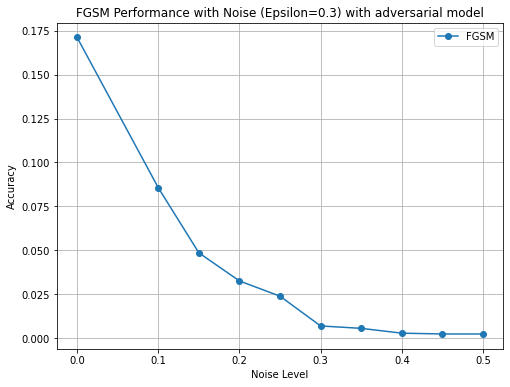

In [100]:
plot_results({"FGSM": fgsm_noise_results_adversarial_03}, "Noise Level", "FGSM Performance with Noise (Epsilon=0.3) with adversarial model")